### Notebook to evaluate on withheld sites 

In [32]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation


import importlib
import logging
import os
import json

from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
from meld_graph.paths import EXPERIMENT_PATH

from meld_graph.evaluation import Evaluator



### look at results

In [33]:
import pandas as pd

In [34]:
model_paths = {
               'robustCombat':'/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-06-05_RMRC_low_smooth_regress_RC/s_0/fold_all/test_H27H28H101',
               'noCombat':'/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-06-16_YRWZ_no_combat/s_0/fold_all/test_H27H28H101'

}

hdf5_file_roots = {
    'robustCombat':"{site_code}_{group}_featurematrix_combat_6_kernels_robustCombat_NewSite.hdf5",
    'noCombat':"{site_code}_{group}_featurematrix_combat_6_kernels_noCombat_NewSite.hdf5"
}



In [35]:
import os
import numpy as np
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.evaluation import (
    load_prediction,
    sens_spec_curves,
    roc_curves,
    plot_roc_multiple,
)
import pandas as pd
import ptitprince as pt

save_dirs = {}
for model in model_paths.keys():
    save_dirs[model] = os.path.join(model_paths[model], "results")

n_vert = len(cohort.cortex_label) * 2
with h5py.File(os.path.join(save_dirs[model], "predictions.hdf5"), "r") as f:
    subjects = list(f.keys())


# number of tresholds to evaluate ROC curve, between 0 & 1.
n_thresh = 101
roc_curves_thresholds = np.linspace(0, 1, n_thresh)
roc_dictionary_bs = {}
roc_dictionary = {}
for model_name in save_dirs.keys():
    cohort = MeldCohort(hdf5_file_root=hdf5_file_roots[model_name],
                        dataset="MELD_dataset_H27H28.csv")
    
    roc_dictionary[model_name] = {
        "sensitivity": np.zeros(n_thresh),
        "sensitivity_plus": np.zeros(n_thresh),
        "specificity": np.zeros(n_thresh),
    }
    

    for si, subj in enumerate(subjects):
        if si % 100 == 0:
            print(si)
        s = MeldSubject(subj, cohort=cohort)
        labels_hemis = {}
        dists = {}
        subject_results = np.zeros((5, n_vert))
        labels = np.zeros(n_vert)
        for hemi in ["lh", "rh"]:
            dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                features=[".on_lh.boundary_zone.mgh"], hemi=hemi, features_to_ignore=[]
            )
            if np.sum(dists[hemi]) == 0:
                dists[hemi] += 200
        labels = np.hstack(
            [
                labels_hemis["lh"][cohort.cortex_mask],
                labels_hemis["rh"][cohort.cortex_mask],
            ]
        )
        borderzones = np.vstack([dists["lh"][cohort.cortex_mask, :], dists["rh"][cohort.cortex_mask, :]]).ravel() < 20
        save_dir = save_dirs[model_name]
        pred_file = os.path.join(save_dir, "predictions.hdf5")
        result_hemis = load_prediction(subj, pred_file, dset="prediction")
        subject_results = np.hstack([result_hemis["lh"], result_hemis["rh"]])
        subject_dictionary = {
            "input_labels": labels,
            "borderzone": borderzones,
            "result": subject_results,
        }
        roc_curves(subject_dictionary, roc_dictionary[model_name], roc_curves_thresholds)
        


0
100
200
0
100
200


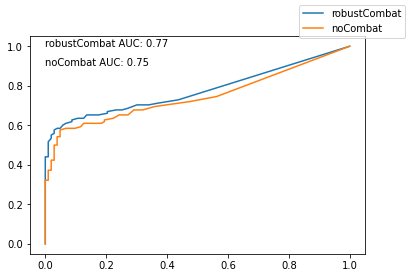

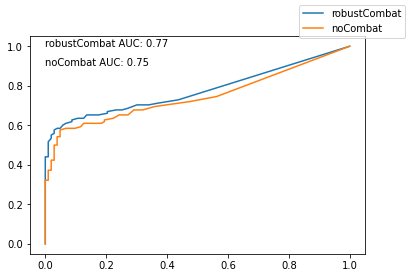

In [36]:
plot_roc_multiple(roc_dictionary, roc_curves_thresholds)

In [63]:
patient_controls = np.array([True if 'FCD' in subj else False for subj in subjects])
nb_patients = patient_controls.sum()
nb_controls = (~patient_controls).sum()

threshold_index = 15
for model in model_paths.keys():
    sensitivity = roc_dictionary[model]['sensitivity'][threshold_index]
    sensitivity_plus = roc_dictionary[model]['sensitivity_plus'][threshold_index]
    specificity = roc_dictionary[model]['specificity'][threshold_index]
    print(f'{model} sensitivity: {sensitivity}/{nb_patients} ({round(sensitivity/nb_patients, 2)})')
    print(f'{model} sensitivity plus: {sensitivity_plus}/{nb_patients} ({round(sensitivity_plus/nb_patients, 2)})')
    print(f'{model} specificity: {specificity}/{nb_controls} ({round(specificity/nb_controls, 2)})')

robustCombat sensitivity: 72.0/118 (0.61)
robustCombat sensitivity plus: 74.0/118 (0.63)
robustCombat specificity: 94.0/103 (0.91)
noCombat sensitivity: 70.0/118 (0.59)
noCombat sensitivity plus: 72.0/118 (0.61)
noCombat specificity: 90.0/103 (0.87)
